In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils import data
from collections import namedtuple
from IPython.display import Image
%matplotlib inline
np.random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda')

In [ ]:
batch_size = 1024
transform = transforms.Compose(
    [transforms.ToTensor(),
#      transforms.Normalize((0.1307,), (0.3081,))
    ])

train_data = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
train_size = train_data.data.shape[0]
val_size, train_size = int(0.20 * train_size), int(0.80 * train_size) # 80 / 20 train-val split
test_size = test_data.data.shape[0]
Metric = namedtuple('Metric', ['train_loss', 'train_error', 'val_error', 'val_loss'])

trainloader = data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=0, 
                                          sampler=data.sampler.SubsetRandomSampler(np.arange(val_size, val_size+train_size))
                                         )
valloader = data.DataLoader(train_data, batch_size=batch_size,
                                        num_workers=0, 
                                        sampler=data.sampler.SubsetRandomSampler(np.arange(0, val_size))
                                         )
                                        
testloader = data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, 
                                         num_workers=0
                                        )

In [ ]:
print(train_size)
print(val_size)
print(test_size)

48000
12000
10000


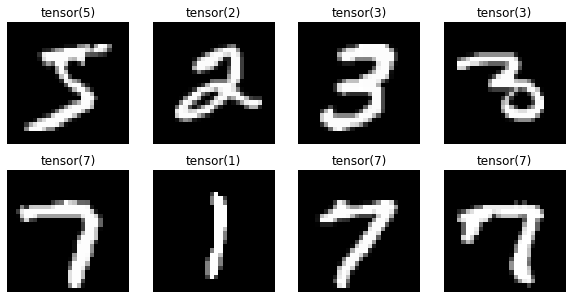

In [ ]:
idxs = [0, 5, 7, 30, 214,3412, 5555, 6666, 7777]
f, a = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    X = train_data.data[idxs[i]]
    Y = train_data.targets[idxs[i]]
    r, c = i // 4, i % 4
    a[r][c].set_title(Y)
    a[r][c].axis('off')
    a[r][c].imshow(X.numpy(),cmap='gray')
plt.draw()

       1        6        6        8        2


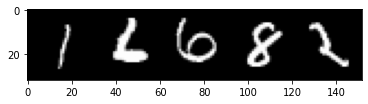

In [ ]:
dataiter = iter(valloader)
images, labels = dataiter.next()
images = torch.reshape(images,(-1,1,28,28))
im = torchvision.utils.make_grid(images[:5])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
print(' '.join('%8s' % labels[j].item() for j in range(5)))

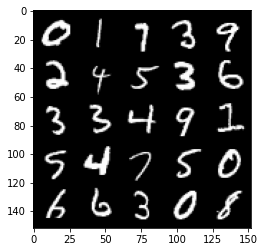

In [ ]:
dataiter = iter(valloader)
images, labels = dataiter.next()
images = torch.reshape(images,(-1,1,28,28))
im = torchvision.utils.make_grid(images[:25],nrow=5)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));


In [ ]:
def one_epoch(epoch, net, loader, optimizer):
    net.train()
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0
    for i, data in enumerate(loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print statistics
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc
    
def train(net, loader, dev_loader, optimizer, epochs):
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        avg_loss_t, acc_t = one_epoch(epoch, net, loader, optimizer)
        avg_loss_v, acc_v = infer(net, dev_loader)
        train_losses.append(avg_loss_t)
        valid_losses.append(avg_loss_v)
        if epoch % 5 == 0:
            print('[%d] loss: %.8f, acc: %.4f' %
                  (epoch + 1, avg_loss_t, acc_t))
            print('[valid] loss: %.8f, acc: %.4f' % (avg_loss_v, acc_v))
    return train_losses, valid_losses

def train_step(net, loader, dev_loader, optimizer, scheduler, epochs):
    net.train()
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        avg_loss_t, acc_t = one_epoch(epoch, net, loader, optimizer)
        avg_loss_v, acc_v = infer(net, dev_loader)
        scheduler.step()
        if epoch % 5 == 0:
            print('[%d] loss: %.8f, acc: %.4f' %
                  (epoch + 1, avg_loss_t, acc_t))
            print('[valid] loss: %.8f, acc: %.4f' % (avg_loss_v, acc_v))
            print("lr: {}".format(optimizer.param_groups[0]['lr']))
            
        train_losses.append(avg_loss_t)
        valid_losses.append(avg_loss_v)
    return train_losses, valid_losses
        
def infer(net, loader):
    net.eval()
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            # forward + backward + optimize
            outputs = net(inputs)
            loss = F.cross_entropy(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    avg_loss = running_loss / total
    
    return avg_loss, acc

### VISUALIZATION ###
def training_plot(a, b):
    plt.figure(1)
    plt.plot(a, 'b', label="train")
    plt.plot(b, 'g', label="valid")
    plt.title('Training/Valid Loss')
    plt.legend()
    plt.show()

Simple mini-batch Gradient Descent: 
$$ \textbf{W} \leftarrow \textbf{W} - \eta \nabla L(\textbf{W}) $$

In [ ]:
### LET'S TRAIN the baseline ###
""" baseline """
model1 = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10), 
                       )
model1 = model1.to(device)
opt1 = torch.optim.SGD(model1.parameters(), lr=0.8)
train_losses, valid_losses = train(model1, trainloader, valloader, opt1, 100)

test_loss, acc_test = infer(model1, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)

[1] loss: 0.00167868, acc: 0.4054
[valid] loss: 0.00152894, acc: 0.4813
[6] loss: 0.00036764, acc: 0.8851
[valid] loss: 0.00032889, acc: 0.9074
[11] loss: 0.00026669, acc: 0.9190
[valid] loss: 0.00036051, acc: 0.8965
[16] loss: 0.00022214, acc: 0.9336
[valid] loss: 0.00024779, acc: 0.9294
[21] loss: 0.00026067, acc: 0.9217
[valid] loss: 0.00023804, acc: 0.9286
[26] loss: 0.00018414, acc: 0.9449
[valid] loss: 0.00021110, acc: 0.9363
[31] loss: 0.00082427, acc: 0.6466
[valid] loss: 0.00075737, acc: 0.6813
[36] loss: 0.00047368, acc: 0.8506
[valid] loss: 0.00056856, acc: 0.8253
[41] loss: 0.00034934, acc: 0.8968
[valid] loss: 0.00040712, acc: 0.8817
[46] loss: 0.00052106, acc: 0.8382
[valid] loss: 0.00041318, acc: 0.8882
[51] loss: 0.00033400, acc: 0.9000
[valid] loss: 0.00034982, acc: 0.8998
[56] loss: 0.00028221, acc: 0.9144
[valid] loss: 0.00030902, acc: 0.9126
[61] loss: 0.00031815, acc: 0.9085
[valid] loss: 0.00031067, acc: 0.9127
[66] loss: 0.00025732, acc: 0.9235
[valid] loss: 0.00

KeyboardInterrupt: ignored

Initialize the weithts: 
- Normally
- Xavier
- Kaiming

<b>Kaiming's():</b><br>
Initialize the weights such that $\frac{1}{2}n_{i} Var[w_{_,i}] = 1$
Therefore initialize $W_{i}$ using a gaussian using mean $0$ and std $\sqrt{\frac{2}{n_{i+1}}}$<br>
source: <a href='https://arxiv.org/abs/1502.01852'> Kaiming's Paper </a>

<b>Xavier's Initialization</b><br>
Similar to Kaiming but did not consider the Relu activation and by default assumed a linear activation. Therefore the factor $\frac{1}{2}$ that we see in the Kaiming's initialization is not present in Xavier. He takes a harmonic mean of the two results for initialization.

Terefore initialize $W_{i}$ using a gaussian using mean $0$ and std $\sqrt{\frac{2}{n_{i+1}+n_{i}}}$<br>
source: <a href='http://proceedings.mlr.press/v9/glorot10a.html'> Xavier's Paper </a>

In [ ]:
# ~N(0,1)
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

# Xavier
def init_xavier(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size()[1]
        fan_out = m.weight.size()[0]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        m.weight.data.normal_(0,std)

# Kaiming 
def init_kam(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size()[1]
        std = np.sqrt(2.0 / fan_in )
        m.weight.data.normal_(0,std)

## Xavier Initialization 

[1] loss: 0.00040182, acc: 0.8759
[valid] loss: 0.00063822, acc: 0.8356
[6] loss: 0.00032799, acc: 0.9005
[valid] loss: 0.00032240, acc: 0.9081
[11] loss: 0.00024709, acc: 0.9266
[valid] loss: 0.00027777, acc: 0.9250
[16] loss: 0.00022604, acc: 0.9336
[valid] loss: 0.00025827, acc: 0.9272
[21] loss: 0.00035799, acc: 0.9062
[valid] loss: 0.00165796, acc: 0.5422
[26] loss: 0.00020183, acc: 0.9388
[valid] loss: 0.00023853, acc: 0.9313
[31] loss: 0.00019851, acc: 0.9395
[valid] loss: 0.00022711, acc: 0.9347
[36] loss: 0.00018668, acc: 0.9418
[valid] loss: 0.00023221, acc: 0.9340
[41] loss: 0.00020259, acc: 0.9381
[valid] loss: 0.00023658, acc: 0.9311
[46] loss: 0.00018444, acc: 0.9436
[valid] loss: 0.00022744, acc: 0.9346
[51] loss: 0.00018692, acc: 0.9414
[valid] loss: 0.00023020, acc: 0.9343
[56] loss: 0.00017532, acc: 0.9451
[valid] loss: 0.00025063, acc: 0.9288
[61] loss: 0.00132825, acc: 0.5145
[valid] loss: 0.00095750, acc: 0.6656
[66] loss: 0.00058919, acc: 0.8185
[valid] loss: 0.00

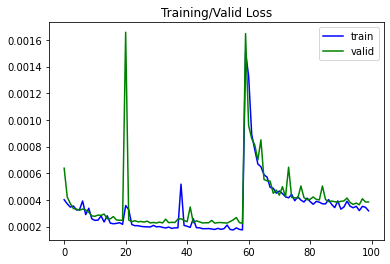

In [ ]:
### LET'S TRAIN the baseline with weight Initialization ###
""" baseline with weight initialization"""
model2 = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10), 
                       )
model2.apply(init_xavier)
model2 = model2.to(device)
opt1 = torch.optim.SGD(model2.parameters(), lr=0.8)
train_losses, valid_losses = train(model2, trainloader, valloader, opt1, 100)

test_loss, acc_test = infer(model2, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)

**With Learning Rate scheduler**
- Exponential Decay
- 1/t Decay
- Step Decay
- ReduceOnPlateau)

In [ ]:
### LET'S TRAIN the baseline ###
""" baseline with scheduler """
model3 = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10),  
                       )
model3.apply(init_xavier)
model3 = model3.to(device)
opt2 = torch.optim.SGD(model3.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(opt2, gamma=0.5, step_size=33)
train_losses, valid_losses = train_step(model3, trainloader, valloader, opt2, scheduler, 100)
test_loss, acc_test = infer(model3, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)

[1] loss: 0.00168839, acc: 0.3882
[valid] loss: 0.00094069, acc: 0.7111
lr: 0.8
[6] loss: 0.00037154, acc: 0.8870
[valid] loss: 0.00031007, acc: 0.9119
lr: 0.8
[11] loss: 0.00025814, acc: 0.9218
[valid] loss: 0.00027120, acc: 0.9200
lr: 0.8
[16] loss: 0.00067597, acc: 0.7849
[valid] loss: 0.00069377, acc: 0.7420
lr: 0.8
[21] loss: 0.00031511, acc: 0.9054
[valid] loss: 0.00040814, acc: 0.8778
lr: 0.8
[26] loss: 0.00026364, acc: 0.9201
[valid] loss: 0.00030227, acc: 0.9112
lr: 0.8


KeyboardInterrupt: ignored

### BatchNorm

In [ ]:
model4 = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.BatchNorm1d(20),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.BatchNorm1d(20),
                       nn.Linear(20, 10),
                       )

model4 = model4.to(device)
opt4 = torch.optim.SGD(model4.parameters(), lr=0.8,weight_decay=1e-4)
loss = nn.CrossEntropyLoss()
train_losses, valid_losses = train(model4, trainloader, valloader, opt4, 100)
test_loss, acc_test = infer(model4, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)

[1] loss: 0.00051951, acc: 0.8428
[valid] loss: 0.00028150, acc: 0.9179
[6] loss: 0.00013855, acc: 0.9562
[valid] loss: 0.00020826, acc: 0.9358
[11] loss: 0.00010556, acc: 0.9672
[valid] loss: 0.00017408, acc: 0.9499
[16] loss: 0.00009121, acc: 0.9706
[valid] loss: 0.00016262, acc: 0.9548
[21] loss: 0.00008019, acc: 0.9746
[valid] loss: 0.00020650, acc: 0.9427
[26] loss: 0.00007521, acc: 0.9757
[valid] loss: 0.00017330, acc: 0.9541


KeyboardInterrupt: ignored

Learning rate Selection

In [ ]:
"""how to know what is the best learning rate? """
""" trial and error """
### LET'S TRAIN the baseline ###
from collections import defaultdict
def find_best_lr(loader, starting_lr=1e-6, gamma=1.4, trials=5):
    lr2loss = defaultdict(list)
    for i in range(trials):
        torch.manual_seed(i)
        net = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10),  
                       )
        net = net.to(device)
        optimizer = torch.optim.SGD(model3.parameters(), lr=starting_lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
        
        last_loss = -1
        for x, y in loader:
            #x = x.to(x)
            #y = y.to(y)
            x = x.to(device)
            y = y.to(device)
            out = net(x)
            optimizer.zero_grad()
            loss = F.cross_entropy(out, y)
            loss.backward()
            lr = optimizer.param_groups[0]['lr']
            if last_loss != -1: lr2loss[lr].append(last_loss - loss.cpu().item())
            optimizer.step()
            scheduler.step()
            last_loss = loss.cpu().item()
    return lr2loss
            
""" baseline with scheduler """
print("# of batches: {}".format(len(trainloader)))
lr2loss = find_best_lr(trainloader, starting_lr=1e-6, gamma=1.4, trials=20)

# of batches: 47


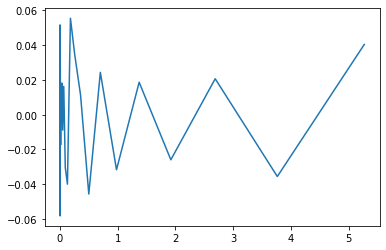

In [ ]:
lrs = list(lr2loss.keys())
vals = [sum(lr2loss[i]) for i in lrs]
plt.plot(lrs, vals)

In [ ]:
lrs[np.argmax(vals)]

0.1822255561721857

In [ ]:
### LET'S TRAIN the baseline ###
""" baseline """
model1 = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10), 
                       )
model1 = model1.to(device)
model1 = model1.apply(init_kam)
opt1 = torch.optim.SGD(model1.parameters(), lr=0.182)
train_losses, valid_losses = train(model1, trainloader, valloader, opt1, 100)
test_loss, acc_test = infer(model1, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)

[1] loss: 0.00122492, acc: 0.5887
[valid] loss: 0.00057335, acc: 0.8304


KeyboardInterrupt: ignored

Continue Training with parameters

In [ ]:
opt1.param_groups[0]['lr'] = 0.09
train_losses, valid_losses = train(model1, trainloader, valloader, opt1, 15)

[1] loss: 0.00036076, acc: 0.8959
[valid] loss: 0.00035175, acc: 0.9018
[6] loss: 0.00027566, acc: 0.9193
[valid] loss: 0.00027855, acc: 0.9219
[11] loss: 0.00023489, acc: 0.9317
[valid] loss: 0.00024187, acc: 0.9317


In [ ]:
test_loss, acc_test = infer(model1, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))

Final TEST SCORE: loss: 0.0002177504912018776 acc: 0.9402


In [ ]:
normalmodel = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10), 
                       )
normalmodel.apply(init_xavier)

n_epochs = 8
model4 = normalmodel.to(device)
loss = nn.CrossEntropyLoss()

#### Adam

$v_{t+1} = \gamma_{1} v_{t} + (1-\gamma_{1}) g_{t}^{2}$

$m_{t+1} = \gamma_{2} m_{t} + (1-\gamma_{2}) g_{t}$

$\hat{v}_{t+1} = \frac{v_{t+1}}{1-\gamma_{1}^{t+1}}$

$\hat{m}_{t+1} = \frac{m_{t+1}}{1-\gamma_{2}^{t+1}}$

$\Delta\theta_{t+1} = \frac{-\eta}{\sqrt{\hat{v}_{t+1}}+\epsilon}\hat{m}_{t+1}$

$\theta_{t+1} = \theta_{t} + \Delta\theta_{t+1}$



$\theta_{t}$ is the parameter at time-step $t$<br>
$\eta$ is the learning rate<br>
$g_{t}$ is the gradient at time-step $t$<br>
$v_{t}$ is the exponentially decaying average of squared gradients at time-step $t$<br>
$m_{t}$ is the exponentially decaying average of gradients at time-step $t$<br>
$\epsilon$ is used to avoid division by zero

Adam OPTIMIZER
[1] loss: 0.00009847, acc: 0.9680
[valid] loss: 0.00018710, acc: 0.9493
[6] loss: 0.00008275, acc: 0.9731
[valid] loss: 0.00020575, acc: 0.9471
Final TEST SCORE: loss: 0.0002111798956990242 acc: 0.9541


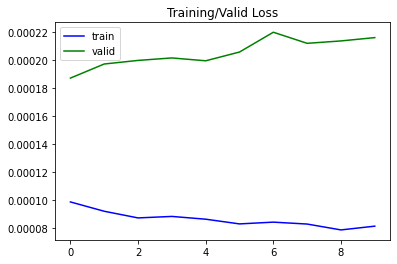

In [ ]:
print("Adam OPTIMIZER")
AdamOptimizer = torch.optim.Adam(normalmodel.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(AdamOptimizer, step_size=4, gamma=0.1)
train_losses, valid_losses = train(normalmodel, trainloader, valloader, AdamOptimizer, 10)
test_loss, acc_test = infer(normalmodel, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)
torch.save(normalmodel.state_dict(),'./adam_model.pt')

In [ ]:
model0 = nn.Sequential(nn.Flatten(),
                       nn.Linear(784, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 20), 
                       nn.ReLU(),
                       nn.Linear(20, 10), 
                       )
model0.to(device)
model0.load_state_dict(torch.load('./adam_model.pt'))
test_loss, acc_test = infer(model0, testloader)
print(test_loss,acc_test)


0.0002111798956990242 0.9541


#### RMSProp

$v_{t+1} = \gamma v_{t} + (1-\gamma) g_{t}^{2}$

$\Delta\theta_{t+1} = \frac{-\eta}{\sqrt{v_{t+1}}+\epsilon}g_{t}$

$\theta_{t+1} = \theta_{t} + \Delta\theta_{t+1}$



$\theta_{t}$ is the parameter at time-step $t$<br>
$\eta$ is the learning rate<br>
$g_{t}$ is the gradient at time-step $t$<br>
$v_{t}$ is the exponentially decaying average of squared gradients at time-step $t$<br>
$\epsilon$ is used to avoid division by zero

RMSProp OPTIMIZER
[1] loss: 0.00153925, acc: 0.7377
[valid] loss: 0.00032400, acc: 0.9070
[6] loss: 0.00022268, acc: 0.9326
[valid] loss: 0.00019838, acc: 0.9438
Final TEST SCORE: loss: 0.0001861390694975853 acc: 0.9456


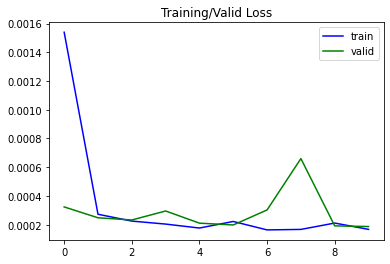

In [ ]:
print("RMSProp OPTIMIZER")
RMSPropOptimizer = torch.optim.RMSprop(normalmodel.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(RMSPropOptimizer, step_size=4, gamma=0.1)
train_losses, valid_losses = train(normalmodel, trainloader, valloader, RMSPropOptimizer, 10)
test_loss, acc_test = infer(normalmodel, testloader)
print("Final TEST SCORE: loss: {} acc: {}".format(test_loss, acc_test))
training_plot(train_losses, valid_losses)

## Gradient Clipping

During experimentation, once the gradient value grows extremely large, it causes an overflow (i.e. NaN) which is easily detectable at runtime or in a less extreme situation, the Model starts overshooting past our Minima; this issue is called the Gradient Explosion Problem.

Gradient clipping will ‘clip’ the gradients or cap them to a Threshold value to prevent the gradients from getting too large.

In [ ]:
#Gradient Clipping 
# `clip_grad_norm` helps prevent the exploding gradient problem. To be used before optimizer.step()during training
torch.nn.utils.clip_grad_norm(model1.parameters(), 0.25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  This is separate from the ipykernel package so we can avoid doing imports until


tensor(0.5042, device='cuda:0')